In [1]:
%load_ext jupyter_ai_magics

In [19]:
import torch
from transformers import HubertModel

model = HubertModel.from_pretrained("rinna/japanese-hubert-base")
model.eval()

wav_input_16khz = torch.randn(1, 10000)
outputs = model(wav_input_16khz)
print(f"Input:   {wav_input_16khz.size()}")  # [1, 10000]
print(f"Output:  {outputs.last_hidden_state.size()}")  # [1, 31, 768]



Input:   torch.Size([1, 10000])
Output:  torch.Size([1, 31, 768])


In [17]:
!ls ../downloads/

 MGS4_オタコン無線集_前編
 MGS4_オタコン無線集_前編.mp3
 MGS4_オタコン無線集_前編.wav
'「METAL GEAR SOLID」 名言集'
'「METAL GEAR SOLID」 名言集.mp3'
'【7 mins Japanese conversation 】with Sayaka (Nihongo Dekita)'
'【7 mins Japanese conversation 】with Sayaka (Nihongo Dekita).mp3'
 【呪術廻戦】五条悟「本気でやれ。もっと欲張れ」
 【呪術廻戦】五条悟「本気でやれ。もっと欲張れ」.mp3
 【呪術廻戦】五条悟「本気でやれ。もっと欲張れ」.wav
'メタルギア 俺が選んだかっこいいシーン集'
 メタルギア俺が選んだかっこいいシーン集
 メタルギア俺が選んだかっこいいシーン集.mp3


809.48_810.22_0.7.mp3, 1184.04_1184.82_0.8.mp3, 1294.82_1296.94_2.1.mp3, 453.28_453.56_0.3.mp3, 1368.86_1369.82_1.0.mp3, 1043.84_1046.56_2.7.mp3, 1281.12_1282.62_1.5.mp3, 175.34_180.28_4.9.mp3, 689.56_693.06_3.5.mp3, 925.94_930.38_4.4.mp3, 1545.18_1548.26_3.1.mp3, 1372.16_1373.88_1.7.mp3, 804.84_806.56_1.7.mp3, 1325.32_1329.68_4.4.mp3, 551.40_556.64_5.2.mp3, 1084.92_1087.68_2.8.mp3, 499.56_504.02_4.5.mp3, 1061.90_1062.92_1.0.mp3, 570.58_577.10_6.5.mp3, 631.62_635.98_4.4.mp3, 1531.16_1534.32_3.2.mp3, 606.06_611.50_5.4.mp3, 1559.98_1561.64_1.7.mp3, 1537.78_1538.88_1.1.mp3, 1120.14_1124.02_3.9.mp3, 942.90_946.14_3.2.mp3, 1313.42_1315.30_1.9.mp3, 581.64_586.14_4.5.mp3, 411.68_418.52_6.8.mp3, 1225.00_1226.78_1.8.mp3, 844.16_848.60_4.4.mp3, 1142.20_1145.46_3.3.mp3, 870.04_873.06_3.0.mp3, 138.12_150.52_12.4.mp3, 1007.94_1010.86_2.9.mp3, 1352.44_1354.02_1.6.mp3, 1114.50_1116.84_2.3.mp3, 755.14_759.14_4.0.mp3, 1233.12_1237.14_4.0.mp3, 621.52_625.38_3.9.mp3, 1390.62_1392.28_1.7.mp3, 1343.48_1345

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 436 samples in 0.000s...
[t-SNE] Computed neighbors for 436 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 436 / 436
[t-SNE] Mean sigma: 0.305692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.174572
[t-SNE] KL divergence after 300 iterations: 1.099021


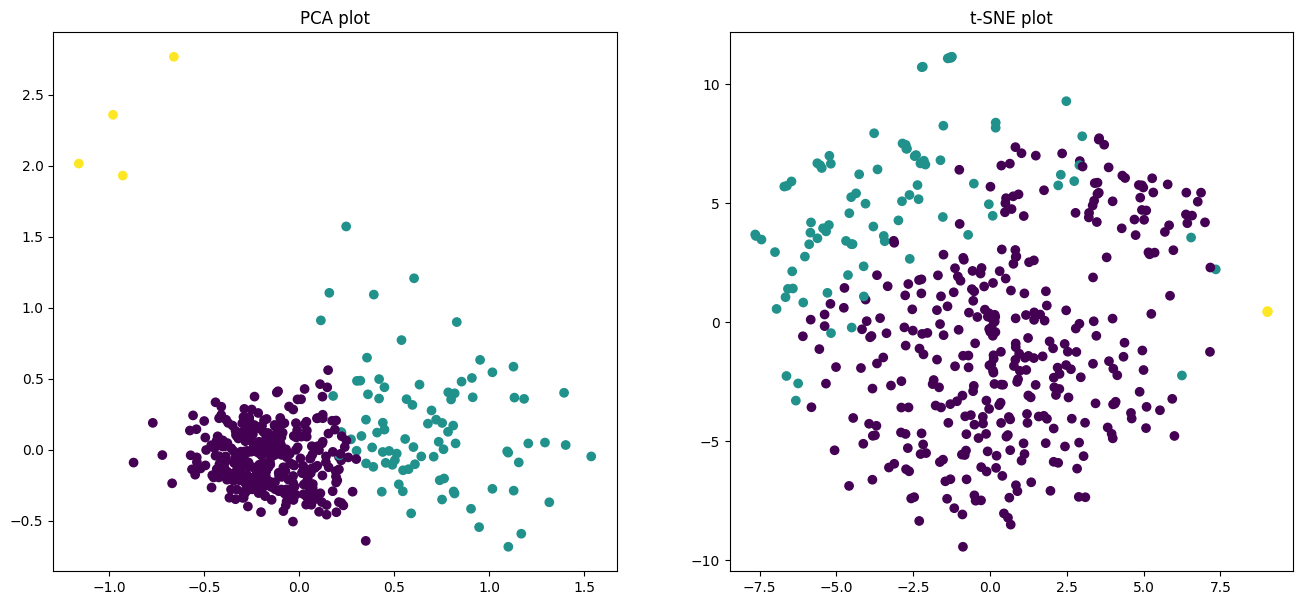

In [4]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pydub import AudioSegment
import librosa
import torch
from transformers import HubertModel

dir = "../mgs_voices"

# HuBERTモデルのロード
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
# model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
model = HubertModel.from_pretrained("rinna/japanese-hubert-base")
model = model.to(device)
model.eval()

# ディレクトリ内のすべてのmp3ファイルのリストを取得
mp3_files = [f for f in os.listdir(dir) if f.endswith('.mp3')]

embeddings = []

# 各mp3ファイルに対して
for mp3_file in mp3_files:
    print(f"{mp3_file}, ", end = "")
    # mp3をwavに変換
    audio = AudioSegment.from_mp3(f"{dir}/{mp3_file}")
    audio.export("temp.wav", format="wav")

    # wavファイルを読み込み、リサンプリング
    wav, sr = librosa.load("temp.wav", sr=16000)

    # 音声データをHuBERTに入力し、埋め込みを取得
    wav = np.array(wav)  # wavをNumPy配列に変換
    inputs = torch.tensor([wav])
    with torch.no_grad():
        outputs = model(inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).numpy())

# numpy配列に変換
embeddings = np.vstack(embeddings)

# k-meansでクラスタリング
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)

# PCAで次元削減
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# t-SNEで次元削減
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# クラスタリング結果をプロット
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(pca_result[:,0], pca_result[:,1], c=kmeans.labels_)
plt.title('PCA plot')
plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=kmeans.labels_)
plt.title('t-SNE plot')
plt.show()


In [6]:
import shutil

# クラスタリング結果に基づいて、output_by_hubertディレクトリにlabel番号のディレクトリを作成し、その下に対応するmp3ファイルを置く
output_dir = "output_by_hubert"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, label in enumerate(kmeans.labels_):
    label_dir = os.path.join(output_dir, str(label))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    shutil.copy(os.path.join(dir, mp3_files[i]), os.path.join(label_dir, mp3_files[i]))